In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
import pywt
import cv2
import PIL.Image
import PIL.ImageChops

In [16]:
class ForensicFeatureExtractor:
    @staticmethod
    def error_level_analysis(image_path, output_quality=90):
        """
        Perform Error Level Analysis (ELA)

        Args:
            image_path (str): Path to input image
            output_quality (int): JPEG compression quality

        Returns:
            numpy.ndarray: Scaled ELA feature map
        """
        original_image = PIL.Image.open(image_path)
        temp_compressed_path = 'temp_compressed.jpg'
        original_image.save(temp_compressed_path, 'JPEG', quality=output_quality)
        compressed_image = PIL.Image.open(temp_compressed_path)
        ela_image = PIL.ImageChops.difference(original_image, compressed_image)
        ela_array = np.array(ela_image)
        scaled_ela = ela_array * (255.0 / np.max(ela_array))
        return scaled_ela

    
    @staticmethod
    def wavelet_noise_features(image, wavelet='db4', levels=3, expected_features=9):
        """
        Extract noise features using wavelet transform.
    
        Args:
            image (numpy.ndarray): Input image
            wavelet (str): Wavelet type
            levels (int): Decomposition levels
            expected_features (int): Expected number of features for the model
    
        Returns:
            numpy.ndarray: Noise feature vector with the specified number of features
        """
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        coeffs = pywt.wavedec2(image, wavelet, level=levels)
        noise_features = []
        for i in range(1, levels + 1):
            subbands = coeffs[i]
            for sb in subbands:
                noise_features.extend([
                    np.mean(np.abs(sb)),
                    np.std(sb),
                    np.max(np.abs(sb))
                ])
        
        if len(noise_features) > expected_features:
            noise_features = noise_features[:expected_features]  # Truncate
        elif len(noise_features) < expected_features:
            noise_features.extend([0] * (expected_features - len(noise_features)))  # Pad with zeros
        
        return np.array(noise_features)

In [17]:
class HybridForensicModel:
    def __init__(self, input_shape=(224, 224, 3), num_classes=2):
        """
        Create hybrid forensic detection model

        Args:
            input_shape (tuple): Input image shape
            num_classes (int): Number of output classes
        """
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        for layer in base_model.layers:
            layer.trainable = False

        image_input = Input(shape=input_shape, name='image_input')
        image_features = base_model(image_input)
        image_features = GlobalAveragePooling2D()(image_features)

        ela_input = Input(shape=(224, 224, 1), name='ela_input')
        ela_conv = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(ela_input)
        ela_pool = tf.keras.layers.MaxPooling2D((2, 2))(ela_conv)
        ela_features = GlobalAveragePooling2D()(ela_pool)

        noise_input = Input(shape=(9,), name='noise_input')

        combined_features = Concatenate()([
            image_features,
            ela_features,
            noise_input
        ])
        
        x = Dense(256, activation='relu')(combined_features)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(num_classes, activation='softmax')(x)

        self.model = Model(inputs=[image_input, ela_input, noise_input], outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def prepare_input(self, image_path):
        """
        Prepare input for the model.
    
        Args:
            image_path (str): Path to input image.
    
        Returns:
            tuple: Preprocessed image, ELA map, and noise features.
        """
        # Read and preprocess the image
        image = cv2.imread(image_path)
        processed_image = cv2.resize(image, (224, 224))
        processed_image = preprocess_input(processed_image)
    
        # Generate and preprocess the ELA map
        ela_map = ForensicFeatureExtractor.error_level_analysis(image_path)
        ela_map_resized = cv2.resize(ela_map, (224, 224))
        ela_map_normalized = np.clip(ela_map_resized / 255.0, 0, 1)  # Normalize to [0, 1]
        ela_map_normalized = (ela_map_normalized * 255).astype(np.uint8)  # Convert to uint8
        
        # Convert to grayscale if needed
        if ela_map_normalized.ndim == 3 and ela_map_normalized.shape[-1] == 3:
            ela_map_normalized = cv2.cvtColor(ela_map_normalized, cv2.COLOR_BGR2GRAY)
        
        # Expand dimensions
        ela_map_expanded = np.expand_dims(ela_map_normalized, axis=-1)  # Add channel dimension
          # Add channel dimension
    
        # Extract noise features
        noise_features = ForensicFeatureExtractor.wavelet_noise_features(image)
    
        return processed_image, ela_map_expanded, noise_features


    def train(self, image_paths, labels, epochs=10, batch_size=32):
        """
        Train the hybrid forensic model

        Args:
            image_paths (list): Paths to training images
            labels (numpy.ndarray): One-hot encoded labels
            epochs (int): Number of training epochs
            batch_size (int): Training batch size
        """
        X_images, X_ela, X_noise = [], [], []
        for img_path in image_paths:
            proc_img, proc_ela, proc_noise = self.prepare_input(img_path)
            X_images.append(proc_img)
            X_ela.append(proc_ela)
            X_noise.append(proc_noise)

        X_images = np.array(X_images)
        X_ela = np.array(X_ela)
        X_noise = np.array(X_noise)

        history = self.model.fit(
            [X_images, X_ela, X_noise],
            labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2
        )
        return history


In [18]:
def load_dataset(genuine_dir, forged_dir):
    """
    Load dataset from separate directories for genuine and forged images.

    Args:
        genuine_dir (str): Path to genuine images directory
        forged_dir (str): Path to forged images directory

    Returns:
        tuple: Image paths and labels
    """
    image_paths = []
    labels = []

    # Process genuine images
    for filename in os.listdir(genuine_dir):
        if filename.endswith(('.jpg', '.png', '.tif', '.tiff')):
            image_paths.append(os.path.join(genuine_dir, filename))
            labels.append([1, 0])  # Label for genuine images

    # Process forged images
    for filename in os.listdir(forged_dir):
        if filename.endswith(('.jpg', '.png', '.tif', '.tiff')):
            image_paths.append(os.path.join(forged_dir, filename))
            labels.append([0, 1])  # Label for forged images

    return image_paths, np.array(labels)


In [19]:
image_folder_path = './CASIA22'
genuine_image_dir = f'{image_folder_path}/Au'
forged_image_dir = f'{image_folder_path}/Tp'

# image_paths, labels = load_dataset(genuine_image_dir, forged_image_dir)

# hybrid_model = HybridForensicModel()
# history = hybrid_model.train(image_paths, labels, epochs=25)

# test_image_path = '/path/to/test/image.jpg'  # Replace with a test image path
# prediction = hybrid_model.predict(test_image_path)
# print("Forgery Probability:", prediction[0][1])

Epoch 1/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 172s 878ms/step - accuracy: 0.5225 - loss: 14.5284 - val_accuracy: 0.6055 - val_loss: 0.8383
Epoch 2/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 183s 952ms/step - accuracy: 0.5334 - loss: 5.8058 - val_accuracy: 0.5980 - val_loss: 0.6749
Epoch 3/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 182s 951ms/step - accuracy: 0.5347 - loss: 3.0022 - val_accuracy: 0.5129 - val_loss: 0.7101
Epoch 4/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 160s 833ms/step - accuracy: 0.5520 - loss: 1.7165 - val_accuracy: 0.4985 - val_loss: 0.7081
Epoch 5/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 162s 844ms/step - accuracy: 0.5448 - loss: 1.2844 - val_accuracy: 0.5388 - val_loss: 0.6884
Epoch 6/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 161s 841ms/step - accuracy: 0.5622 - loss: 1.0819 - val_accuracy: 0.5791 - val_loss: 0.6713
Epoch 7/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 169s 879ms/step - accuracy: 0.5734 - loss: 0.9226 - val_accuracy: 0.5766 - val_loss: 0.6719
Epoch 8/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 165s 861ms/step - accuracy: 0.5621 

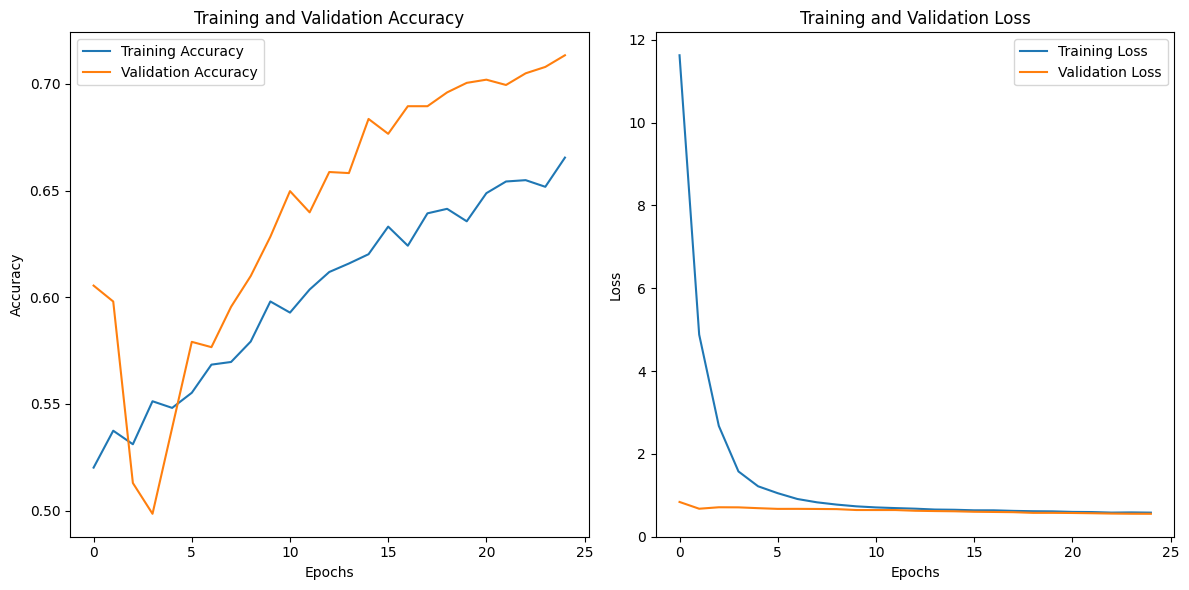

79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step
Accuracy: 0.7118
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1466
           1       0.61      0.83      0.71      1046

    accuracy                           0.71      2512
   macro avg       0.73      0.73      0.71      2512
weighted avg       0.74      0.71      0.71      2512



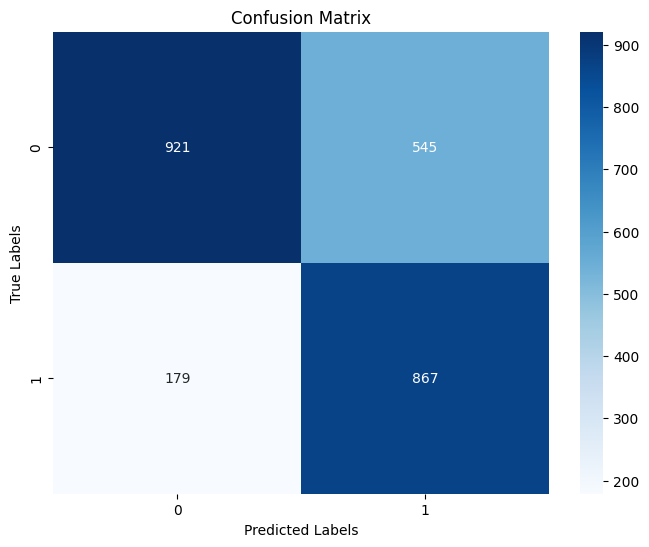

Test Evaluation Metrics: {'accuracy': 0.7117834394904459, 'precision': 0.7443111160685727, 'recall': 0.7117834394904459, 'f1_score': 0.7126865798402019}


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class HybridForensicModelEvaluator:
    def __init__(self, model):
        """
        Initialize the evaluator with a trained HybridForensicModel instance.

        Args:
            model (HybridForensicModel): Trained model to evaluate.
        """
        self.model = model

    def prepare_dataset(self, image_paths, labels, test_size=0.2, random_state=42):
        """
        Split data into training and testing sets.

        Args:
            image_paths (list): List of image file paths.
            labels (numpy.ndarray): One-hot encoded labels.
            test_size (float): Proportion of data to use for testing.
            random_state (int): Random seed for reproducibility.

        Returns:
            tuple: Train and test splits for image paths and labels.
        """
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            image_paths, labels, test_size=test_size, random_state=random_state
        )
        return train_paths, test_paths, train_labels, test_labels

    def evaluate(self, image_paths, labels):
        """
        Evaluate the model on a dataset.

        Args:
            image_paths (list): List of image file paths.
            labels (numpy.ndarray): One-hot encoded true labels.

        Returns:
            dict: Evaluation metrics (accuracy, precision, recall, F1-score).
        """
        X_images, X_ela, X_noise = [], [], []

        # Prepare inputs
        for img_path in image_paths:
            proc_img, proc_ela, proc_noise = self.model.prepare_input(img_path)
            X_images.append(proc_img)
            X_ela.append(proc_ela)
            X_noise.append(proc_noise)

        X_images = np.array(X_images)
        X_ela = np.array(X_ela)
        X_noise = np.array(X_noise)

        # Get predictions
        predictions = self.model.model.predict([X_images, X_ela, X_noise])
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        # Compute metrics
        accuracy = accuracy_score(true_classes, predicted_classes)
        report = classification_report(true_classes, predicted_classes, output_dict=True)

        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(true_classes, predicted_classes))

        # Confusion matrix
        conf_matrix = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


        return {
            "accuracy": accuracy,
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1_score": report["weighted avg"]["f1-score"]
        }
    
    def plot_training_history(self, history):
        """
        Plot training and validation accuracy and loss.

        Args:
            history (History): Training history object from model.fit().
        """
        # Plot accuracy
        plt.figure(figsize=(12, 6))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
# Example Usage
# Assuming `image_paths` is a list of all image paths and `labels` is a numpy array of one-hot encoded labels.
image_paths, labels = load_dataset(genuine_image_dir, forged_image_dir)

# Instantiate your model (ensure it's already trained)
hybrid_model = HybridForensicModel()

# Instantiate the evaluator
evaluator = HybridForensicModelEvaluator(hybrid_model)

# Split data into train and test sets
train_paths, test_paths, train_labels, test_labels = evaluator.prepare_dataset(image_paths, labels, test_size=0.2)

# Train the model
history = hybrid_model.train(train_paths, train_labels, epochs=25, batch_size=42)

# Plot training history
evaluator.plot_training_history(history)

# Evaluate the model
evaluation_metrics = evaluator.evaluate(test_paths, test_labels)
print("Test Evaluation Metrics:", evaluation_metrics)

